# Raster Viewer for Suhora

C:\Users\lenovo\anaconda3\Lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


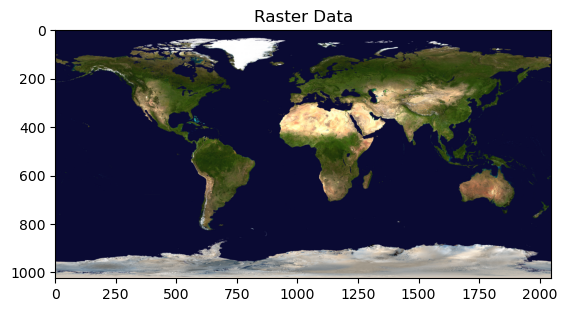

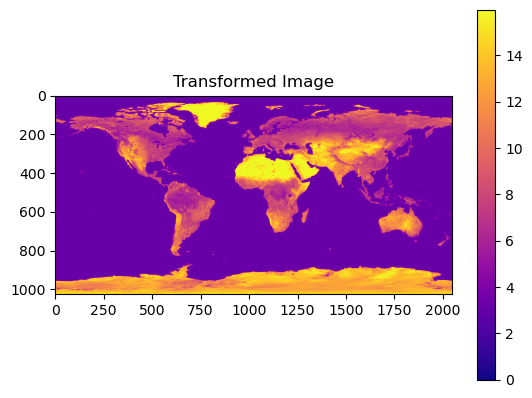

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import filedialog
import rasterio
from rasterio.plot import show

#RASTER VIEWER
class RasterViewer:
    def __init__(self, master):
        self.master = master
        self.master.title("Raster Viewer")

        self.fig, self.ax = plt.subplots()
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.master)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

        self.raster_data = None
        self.raster_src = None
        self.extent = None

        self.load_button = tk.Button(self.master, text="Load Raster", command=self.load_raster)
        self.load_button.pack()

        self.band_combinations = tk.StringVar()
        self.band_combinations.set("RGB") 
        self.band_combination_menu = tk.OptionMenu(self.master, self.band_combinations, "RGB", "Red", "Green", "Blue")
        self.band_combination_menu.pack()

        self.apply_filter_button = tk.Button(self.master, text="Apply Filter", command=self.apply_filter)
        self.apply_filter_button.pack()

        self.calculate_statistics_button = tk.Button(self.master, text="Calculate Statistics", command=self.calculate_statistics)
        self.calculate_statistics_button.pack()

        self.apply_math_transformation_button = tk.Button(self.master, text="Apply Math Transformation", command=self.apply_math_transformation)
        self.apply_math_transformation_button.pack()

        self.canvas.draw()

        self.canvas.mpl_connect("scroll_event", self.zoom)
        self.canvas.mpl_connect("button_press_event", self.pan_start)
        self.canvas.mpl_connect("motion_notify_event", self.pan_move)
        self.canvas.mpl_connect("button_release_event", self.pan_end)

        self.panning = False
        self.pan_start_x = 0
        self.pan_start_y = 0
        
#LOADING
    def load_raster(self):
        file_path = filedialog.askopenfilename(filetypes=[("TIFF files", "*.tif;*.tiff")])
        if file_path:
            with rasterio.open(file_path) as src:
                self.raster_data = src.read()
                self.raster_src = src
                self.update_band_combination()
                self.ax.set_title("Raster Data")
                self.extent = self.ax.get_xlim(), self.ax.get_ylim()

            self.canvas.draw()
#BAND COMBINATION CHANGE
    def update_band_combination(self):
        band_combination = self.band_combinations.get()
        if band_combination == "RGB":
            show(self.raster_src, ax=self.ax, transform=self.raster_src.transform)
        elif band_combination == "Red":
            show(self.raster_src.read(1), ax=self.ax, cmap="Reds", transform=self.raster_src.transform)
        elif band_combination == "Green":
            show(self.raster_src.read(2), ax=self.ax, cmap="Greens", transform=self.raster_src.transform)
        elif band_combination == "Blue":
            show(self.raster_src.read(3), ax=self.ax, cmap="Blues", transform=self.raster_src.transform)

    def apply_filter(self):
        if self.raster_data is not None:
            # Example: Applying a simple median filter to one band
            filtered_band = np.median(self.raster_data[0], axis=0)  # Apply along the time axis for multi-temporal data

            plt.figure()
            plt.imshow(filtered_band, cmap='viridis')
            plt.title("Filtered Image")
            plt.colorbar()
            plt.show()
        else:
            tk.messagebox.showwarning("No Raster Loaded", "Please load a raster first.")
#NUMPY FOR ARRAY MANIPULATION
    def calculate_statistics(self):
        if self.raster_data is not None:
            band_mean = np.mean(self.raster_data[0])
            band_std = np.std(self.raster_data[0])

            tk.messagebox.showinfo("Statistics", f"Mean: {band_mean}\nStandard Deviation: {band_std}")
        else:
            tk.messagebox.showwarning("No Raster Loaded", "Please load a raster first.")

    def apply_math_transformation(self):
        if self.raster_data is not None:
            transformed_band = np.sqrt(self.raster_data[0])
            plt.figure()
            plt.imshow(transformed_band, cmap='plasma')  # Change 'viridis' to your desired colormap
            plt.title("Transformed Image")
            plt.colorbar()
            plt.show()
  
        else:
            tk.messagebox.showwarning("No Raster Loaded", "Please load a raster first.")
 #ZOOM           
    def zoom(self, event):
        if event.button == "up":
            scale_factor = 1.2
        elif event.button == "down":
            scale_factor = 1 / 1.2
        else:
            return

        self.ax.set_xlim([event.xdata - (event.xdata - self.ax.get_xlim()[0]) * scale_factor,
                          event.xdata + (self.ax.get_xlim()[1] - event.xdata) * scale_factor])
        self.ax.set_ylim([event.ydata - (event.ydata - self.ax.get_ylim()[0]) * scale_factor,
                          event.ydata + (self.ax.get_ylim()[1] - event.ydata) * scale_factor])

        self.canvas.draw()
#PAN
        
    def pan_start(self, event):
        if event.button == 1:
            self.panning = True
            self.pan_start_x = event.x
            self.pan_start_y = event.y

    def pan_move(self, event):
        if self.panning:
            dx = event.x - self.pan_start_x
            dy = event.y - self.pan_start_y
            self.pan_start_x = event.x
            self.pan_start_y = event.y

            self.ax.set_xlim([x - dx for x in self.ax.get_xlim()])
            self.ax.set_ylim([y - dy for y in self.ax.get_ylim()])

            self.canvas.draw()

    def pan_end(self, event):
        if event.button == 1:
            self.panning = False



if __name__ == "__main__":
    root = tk.Tk()
    app = RasterViewer(root)
    root.mainloop()


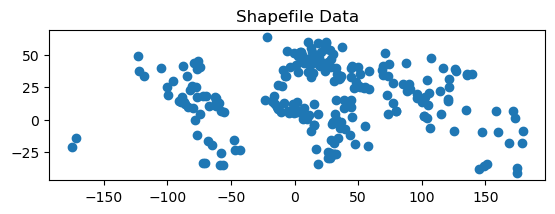

In [7]:
#SHAPEFILE
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import filedialog
import geopandas as gpd

class ShapeFile:
    def __init__(self, master):
        self.master = master
        self.master.title("Shapefile")

        self.fig, self.ax = plt.subplots()
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.master)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

        self.shapefile_data = None
        self.extent = None

        self.load_shapefile_button = tk.Button(self.master, text="Load Shapefile", command=self.load_shapefile)
        self.load_shapefile_button.pack()

        self.show_attribute_chart_button = tk.Button(self.master, text="Show Attribute Chart", command=self.show_attribute_chart)
        self.show_attribute_chart_button.pack()

        self.canvas.draw()

    def load_shapefile(self):
        file_path = filedialog.askopenfilename(filetypes=[("Shapefile files", "*.shp")])
        if file_path:
            self.shapefile_data = gpd.read_file(file_path)
            self.extent = self.shapefile_data.total_bounds
            self.ax = self.shapefile_data.plot(ax=self.ax)
            self.ax.set_title("Shapefile Data")

            self.canvas.draw()

    def show_attribute_chart(self):
        if self.shapefile_data is not None:
            attribute_column = filedialog.askstring("Attribute Column", "Enter attribute column name:")
            if attribute_column and attribute_column in self.shapefile_data.columns:
                plt.figure()
                self.shapefile_data[attribute_column].value_counts().plot(kind='bar')
                plt.title(f'Attribute Chart: {attribute_column}')
                plt.xlabel(attribute_column)
                plt.ylabel('Count')
                plt.show()
            else:
                tk.messagebox.showwarning("Invalid Column", "Please enter a valid attribute column name.")
        else:
            tk.messagebox.showwarning("No Shapefile Loaded", "Please load a shapefile first.")

if __name__ == "__main__":
    root = tk.Tk()
    app = ShapeFile(root)
    root.mainloop()
